In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# pip install opencv-python

In [3]:
from tqdm import tqdm
import cv2
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.offline as offline
from plotly.subplots import make_subplots
import random
import pandas as pd
import numpy as np
import cv2
import os
import tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *

from keras.applications.inception_v3 import preprocess_input
offline.init_notebook_mode(connected = True)

In [4]:
# pip install tensorflow

In [5]:
class Load_Datasets():
    def __init__(self,path="C:/Users/hp/Downloads/eye reaction last",size_images= (350,350),gray=False):
        self.path = path
        self.gray = gray
        self.size_images = size_images
    def load_images(self,p):
        images = []
        labels = []
        for emotion in tqdm(os.listdir(p)):
            new_p = os.path.join(p,emotion)
            for image in os.listdir(new_p):
                if self.gray:
                    image = cv2.imread(os.path.join(new_p,image),cv2.IMREAD_GRAYSCALE)
                    
                else:
                    image = cv2.imread(os.path.join(new_p,image))
                image = cv2.resize(image,self.size_images)
                images.append(image)
                labels.append(emotion)
        if self.gray:
            images = np.array(images)
            labels = np.array(labels)
            images = images.reshape(images.shape[0],images.shape[1]*images.shape[2])
            images = images.astype("float")/255
            
        return images,labels
    def load_data(self):
        for file in os.listdir(self.path):
            if file=="train":
                print("*"*100)
                print("Loading Training Dataset")
                train_path = os.path.join(self.path,"train")
                train_x,train_y = self.load_images(train_path)
            else:
                if file=="test":
                    print("*"*100)
                    print("Loading Testing Dataset")
                    test_path = os.path.join(self.path,"test")
                    test_x,test_y = self.load_images(test_path)
                else:
                    print("there is no train test folder")
        return train_x,train_y,test_x,test_y

In [6]:
data = Load_Datasets()
train_x,train_y,test_x,test_y = data.load_data()

****************************************************************************************************
Loading Testing Dataset


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.44it/s]


****************************************************************************************************
Loading Training Dataset


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.35s/it]


In [7]:
def create_dataframe(train_y,test_y):
    dist = []
    df= pd.DataFrame()
    df_test= pd.DataFrame()
    df["labels"] = train_y
    df["Type"] = "train"
    df_test["labels"] = test_y
    df_test["Type"] = "test"
    df = df.append(df_test,ignore_index = True)
    return df
df = create_dataframe(train_y,test_y)

C:\Users\hp\AppData\Local\Temp\ipykernel_33816\3287092423.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [8]:
train = df[df["Type"]=="train"]
train_dist =  pd.DataFrame(train["labels"].value_counts() )
train_dist= train_dist.reset_index()

test = df[df["Type"]=="test"]
test_dist =  pd.DataFrame(test["labels"].value_counts() )
test_dist= test_dist.reset_index()


In [9]:
def plot_data_distribution(data,label):
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.5, 0.5],
        row_heights=[0.5],
        specs=[[ {"type": "pie"}, {"type": "Funnelarea"}]])


    fig.add_trace(go.Pie(
        labels=data["index"], 
        values=data["labels"],
        legendgroup="group",
        textinfo='percent+label'), 
        row=1, col=1)

    fig.add_trace(go.Funnelarea(
       values=data['labels'], labels=data['index'], name='Emotions data distribution',
        title = {"position": "top center",}), 
                        row=1, col=2)

    fig.update_layout(height=500,width=1000, bargap=0.2,
                      margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                      title_text=f"{label} Data Distribution",
                      template="plotly_white",
                      title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                      font=dict(color='#8a8d93'), 
                      hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                      showlegend=False)
    fig.show()

In [10]:
plot_data_distribution(train_dist,"Training")

In [11]:
plot_data_distribution(test_dist,"Testing")

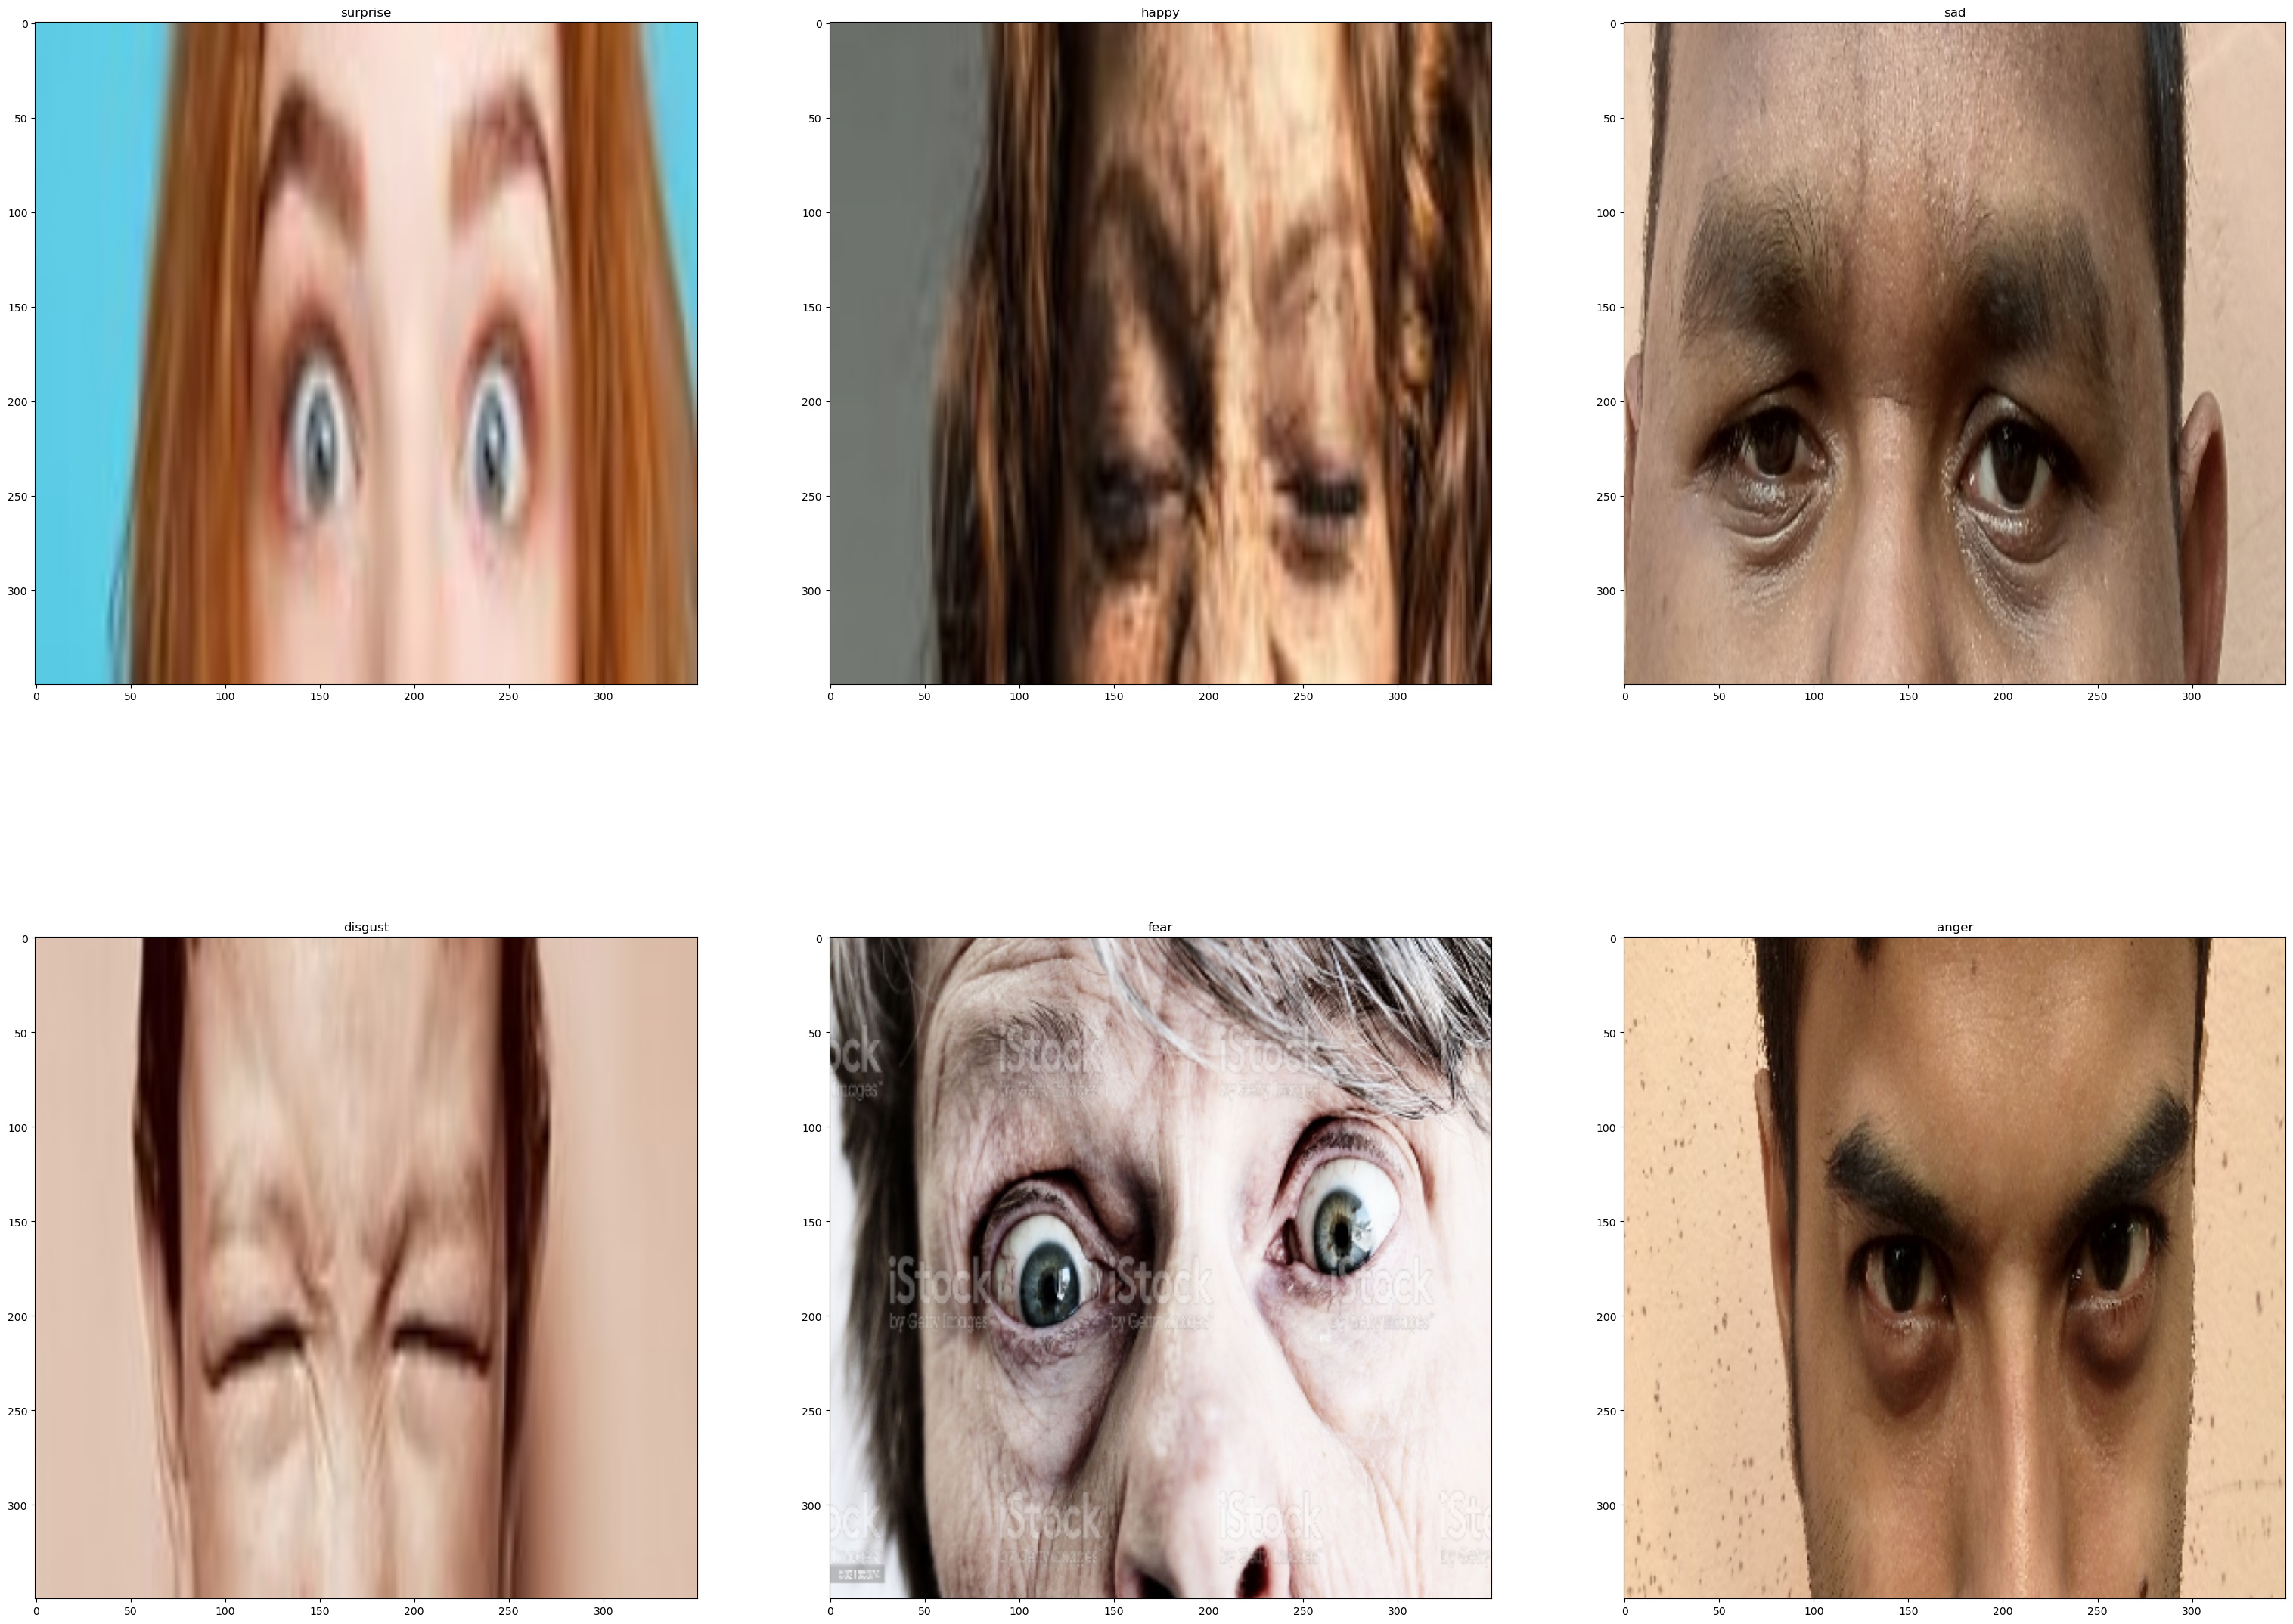

In [12]:
#TrainingImages
def get_random_unique_sample(images,labels):
    l = []
    imgs = []
    labels_array = np.array(labels)
    uniq = list(np.unique(labels_array))
    while len(l)!=len(uniq):
        r = random.randint(0,len(images)-1)
        unknown = labels[r]
        if unknown not in l:
            l.append(labels[r])
            imgs.append(images[r])
    del labels_array
    del uniq
    return  imgs,l
def show_images(images, rows = 1, titles = None):
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(rows),int( np.ceil(n_images/float(rows))), n +1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
imgs,la = get_random_unique_sample(train_x,train_y)
show_images(imgs,titles=la,rows=2)

In [13]:
train_y = np.array(train_y)
train_x = np.array(train_x)
test_y = np.array(test_y)
test_x = np.array(test_x)
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
train_y = to_categorical(train_y)
test_y = encoder.fit_transform(test_y)
test_y = to_categorical(test_y)

In [14]:
def get_features(pr_model, data,width=350):
    cnn_model = pr_model(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)
    features = cnn_model.predict(data, batch_size=5, verbose=1)
    return features

In [15]:
width =350
inception_features = get_features(InceptionV3, train_x)
xception_features = get_features(Xception,train_x)
features = np.concatenate([inception_features, xception_features],axis=1)

54/54 [==============================] - 75s 1s/step


In [16]:

# callbacks_list = [
# tensorflow.keras.callbacks.EarlyStopping(
# monitor='val_accuracy',
# patience=200,
# ),
# tensorflow.keras.callbacks.ModelCheckpoint(
# filepath='../output/final_model.h5',
# monitor='val_accuracy',
# save_best_only=True,
# )
# ]

In [17]:
model = Sequential()
model.add(layers.Dense(1020,activation= "relu",input_shape= (features.shape[1],)))
model.add(layers.Dense(900,activation = "relu"))
model.add(layers.Dense(800,activation="relu"))
model.add(Dropout(0.5))
#model.add(layers.Dense(700,activation="relu"))
model.add(layers.Dense(6,activation="softmax"))
model.compile(optimizer = "adam" ,loss = "categorical_crossentropy" , metrics = ["accuracy"])
history = model.fit(features,train_y,batch_size = 5,epochs = 100)

Epoch 1/100
54/54 [==============================] - 8s 99ms/step - loss: 2.1038 - accuracy: 0.2556
Epoch 2/100
54/54 [==============================] - 5s 99ms/step - loss: 1.5488 - accuracy: 0.3852
Epoch 3/100
54/54 [==============================] - 5s 99ms/step - loss: 1.1794 - accuracy: 0.5407
Epoch 4/100
54/54 [==============================] - 5s 96ms/step - loss: 1.1139 - accuracy: 0.5667
Epoch 5/100
54/54 [==============================] - 5s 95ms/step - loss: 1.0090 - accuracy: 0.6111
Epoch 6/100
54/54 [==============================] - 5s 91ms/step - loss: 0.6924 - accuracy: 0.7407
Epoch 7/100
54/54 [==============================] - 5s 89ms/step - loss: 0.5347 - accuracy: 0.7963
Epoch 8/100
54/54 [==============================] - 5s 92ms/step - loss: 0.5999 - accuracy: 0.7963
Epoch 9/100
54/54 [==============================] - 5s 92ms/step - loss: 0.2955 - accuracy: 0.9037
Epoch 10/100
54/54 [==============================] - 5s 92ms/step - loss: 0.2721 - accuracy: 0.9333

In [18]:
inception_features = get_features(InceptionV3,test_x)
xception_features = get_features(Xception,test_x)
features_test = np.concatenate([inception_features, xception_features],axis=1)

28/28 [==============================] - 31s 1s/step


In [19]:
eva = model.evaluate(features_test,test_y)

5/5 [==============================] - 0s 9ms/step - loss: 1.8655 - accuracy: 0.7391


In [20]:
model.save("/kaggle/Functional_model.h5")

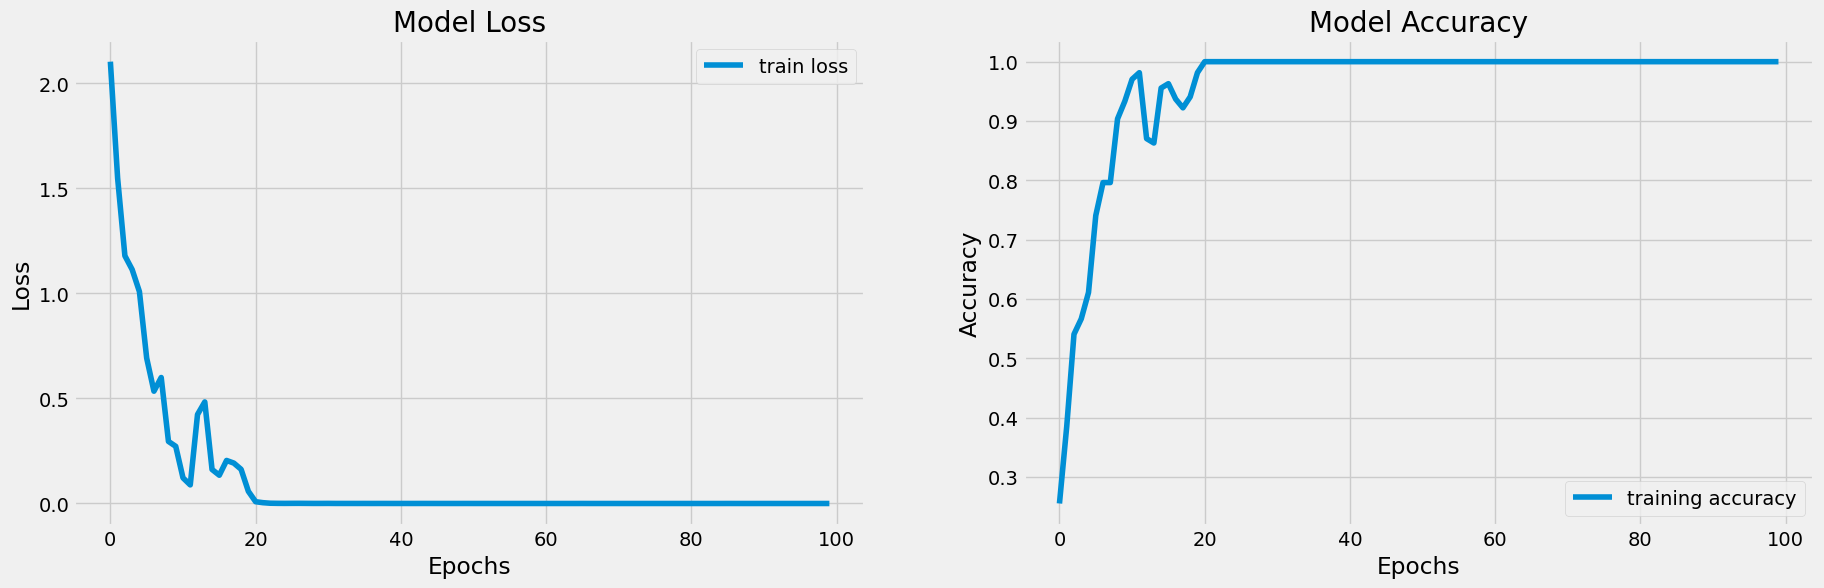

In [21]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()

In [22]:
pred = model.predict(features_test)
y_decode = np.argmax(pred,axis=1)
y_decode1 = encoder.inverse_transform(y_decode)

5/5 [==============================] - 0s 8ms/step


# **Predicted Emotions**

In [23]:
#predicted Emotions
imgs,la = get_random_unique_sample(test_x,y_decode1)
# show_images(imgs,titles=la,rows=1)

# **ReBuilding Model Classification From ANN to show Difference between ANN and Inception+Exception**

In [24]:
data = Load_Datasets(gray=True)
x_train,y_train,x_test,y_test = data.load_data()
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


****************************************************************************************************
Loading Testing Dataset


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.99it/s]


****************************************************************************************************
Loading Training Dataset


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.99it/s]


In [25]:
model = Sequential()
model.add(layers.Dense(1020,activation= "relu",input_shape= (x_train.shape[1],)))
model.add(layers.Dense(900,activation = "relu"))
model.add(layers.Dense(100,activation="relu"))
model.add(layers.Dense(200,activation="relu"))
model.add(layers.Dense(150,activation="relu"))
model.add(layers.Dense(50,activation="relu"))
model.add(layers.Dense(y_train.shape[1],activation="softmax"))
model.compile(optimizer = "adam" ,loss = "categorical_crossentropy" , metrics = ["accuracy"])

In [26]:
model.fit(x_train,y_train,batch_size =5,epochs = 100,validation_split=0.1)

Epoch 1/100
49/49 [==============================] - 102s 2s/step - loss: 17.3220 - accuracy: 0.1481 - val_loss: 6.1347 - val_accuracy: 0.0000e+00
Epoch 2/100
49/49 [==============================] - 89s 2s/step - loss: 2.6016 - accuracy: 0.2346 - val_loss: 2.0805 - val_accuracy: 0.0000e+00
Epoch 3/100
49/49 [==============================] - 89s 2s/step - loss: 1.9408 - accuracy: 0.1687 - val_loss: 2.7184 - val_accuracy: 0.0000e+00
Epoch 4/100
49/49 [==============================] - 98s 2s/step - loss: 1.7890 - accuracy: 0.2469 - val_loss: 1.9125 - val_accuracy: 0.0000e+00
Epoch 5/100
49/49 [==============================] - 87s 2s/step - loss: 1.7704 - accuracy: 0.2840 - val_loss: 2.5458 - val_accuracy: 0.0000e+00
Epoch 6/100
49/49 [==============================] - 89s 2s/step - loss: 1.7019 - accuracy: 0.3004 - val_loss: 2.1682 - val_accuracy: 0.0000e+00
Epoch 7/100
49/49 [==============================] - 89s 2s/step - loss: 1.7325 - accuracy: 0.3374 - val_loss: 2.0095 - val_accu

In [27]:
loss,acc = model.evaluate(x_test,y_test, verbose=0)
print("         Using ANN           ")
print(f"loss on testing is {loss}\naccuracy on testing {acc}")

         Using ANN           
loss on testing is 1.8028342723846436
accuracy on testing 0.18840579688549042
